Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4700 - loss: 1.6255 - val_accuracy: 0.6750 - val_loss: 0.9328
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7515 - loss: 0.8281 - val_accuracy: 0.7150 - val_loss: 0.7722
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8195 - loss: 0.6014 - val_accuracy: 0.7450 - val_loss: 0.6566
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8645 - loss: 0.4791 - val_accuracy: 0.7650 - val_loss: 0.6163
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8885 - loss: 0.3925 - val_accuracy: 0.7700 - val_loss: 0.6068

Adversarially Trained Model Accuracy: 77.00%
Adversarially Trained Model with Tangent Prop Accuracy: 71.00%

Classifying 200 test samples...
Progress: 20/200
Progress: 40/200
Progress: 60/200
Progress: 80/200
Progress: 100/200
Progress: 120/200
Progress: 140/200
Progress: 160/200
Progress: 180/200
Progress: 200/200

Tangent Distance Classifier Accuracy: 77.50%


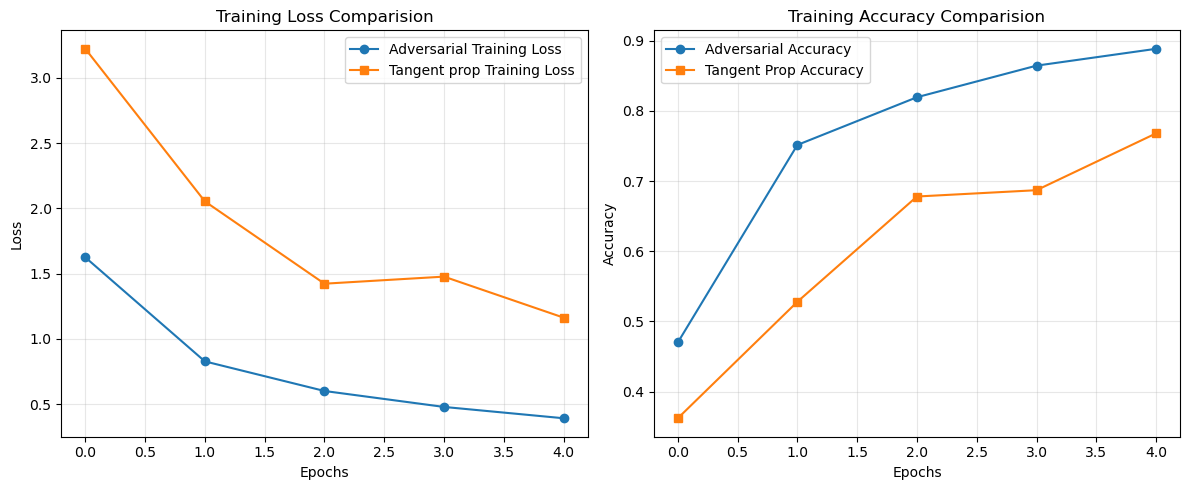

Adversarial Training Accuracy: 77.00%
Tangent Prop Accuracy:71.00%
Tangent Distance classifier: 77.50%


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Layer
import matplotlib.pyplot as plt

(x_train,y_train),(x_test,y_test)=fashion_mnist.load_data()
subset_size=1000
x_train=x_train[:subset_size]/255.0
y_train=y_train[:subset_size]
x_test=x_test[:200]/255.0
y_test=y_test[:200]

def create_model():
    model=Sequential([
        Flatten(input_shape=(28,28)),
        Dense(64,activation='relu'),
        Dense(10,activation='softmax')
    ])
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model
def generate_adversarial_examples(model,x,y,epsilon):
    x_tensor=tf.convert_to_tensor(x,dtype=tf.float32)
    y_tensor=tf.convert_to_tensor(y,dtype=tf.int64)
    with tf.GradientTape() as tape:
        tape.watch(x_tensor)
        predictions=model(x_tensor)
        loss=tf.keras.losses.sparse_categorical_crossentropy(y_tensor,predictions)
    gradients=tape.gradient(loss,x_tensor)
    signed_grad=tf.sign(gradients)
    x_adv=x_tensor+epsilon*signed_grad
    x_adv=tf.clip_by_value(x_adv,0,1)
    return x_adv.numpy()

model_adv=create_model()
x_adv=generate_adversarial_examples(model_adv,x_train,y_train,epsilon=0.1)
x_combined=np.concatenate([x_train,x_adv])
y_combined=np.concatenate([y_train,y_train])

history_adv=model_adv.fit(x_combined,y_combined,epochs=5,validation_data=(x_test,y_test),verbose=1)
loss_adv,accuracy_adv=model_adv.evaluate(x_test,y_test,verbose=0)
print(f'\nAdversarially Trained Model Accuracy: {accuracy_adv*100:.2f}%')

#2
class TangentProp(Layer):
    def call(self,x):
        perturbation=tf.random.normal(shape=tf.shape(x),stddev=0.1)
        return x+perturbation

model_tangent_prop = create_model()
model_tangent_prop.add(TangentProp())
history_tangent_prop = model_tangent_prop.fit(x_train,y_train,epochs=5,validation_data=(x_test,y_test),verbose=0)
loss,accuracy_tangent_prop = model_tangent_prop.evaluate(x_test,y_test,verbose=0)
print(f'Adversarially Trained Model with Tangent Prop Accuracy: {accuracy_tangent_prop*100:.2f}%')

def tangent_distance(x1,x2):
    return np.linalg.norm(x1-x2)
def classify_with_tangent_distance(x_train,y_train,x_test):
    x_train_flat=x_train.reshape(x_train.shape[0],-1)
    x_test_flat=x_test.reshape(x_test.shape[0],-1)
    y_pred=[]
    print(f"\nClassifying {len(x_test_flat)} test samples...")
    for i,test_sample in enumerate(x_test_flat):
        if (i+ 1)%20 ==0:
            print(f"Progress: {i+1}/{len(x_test_flat)}")
        distances=[tangent_distance(test_sample,train_sample) for train_sample in x_train_flat]
        nearest_index=np.argmin(distances)
        y_pred.append(y_train[nearest_index])
    return np.array(y_pred)
y_pred_tangent=classify_with_tangent_distance(x_train,y_train,x_test)
accuracy_tangent=np.mean(y_pred_tangent==y_test)
print(f"\nTangent Distance Classifier Accuracy: {accuracy_tangent*100:.2f}%")

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history_adv.history['loss'],label='Adversarial Training Loss',marker='o')
plt.plot(history_tangent_prop.history['loss'],label='Tangent prop Training Loss',marker='s')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparision')
plt.legend()
plt.grid(True,alpha=0.3)
plt.subplot(1,2,2)
plt.plot(history_adv.history['accuracy'],label='Adversarial Accuracy',marker='o')
plt.plot(history_tangent_prop.history['accuracy'],label='Tangent Prop Accuracy',marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Comparision')
plt.legend()
plt.grid(True,alpha=0.3)
plt.tight_layout()
plt.show()
print(f"Adversarial Training Accuracy: {accuracy_adv*100:.2f}%")
print(f"Tangent Prop Accuracy:{accuracy_tangent_prop*100:.2f}%")
print(f"Tangent Distance classifier: {accuracy_tangent*100:.2f}%")